In [1]:
import numpy as np
from scipy.linalg import qr
from dppy.finite_dpps import FiniteDPP

In [18]:
import numpy as np
import pandas as pd
import pickle

## Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

## Embeddings
from flair.data import Sentence
from flair.embeddings import FlairEmbeddings

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

In [19]:
flair_embedding_forward = FlairEmbeddings('news-forward')

In [20]:
def get_flair_embedding(sent):
    sentence = Sentence(sent)
    flair_embedding_forward.embed(sentence)
    all_tensors = torch.zeros(flair_embedding_forward.embedding_length)
    for token in sentence:
        all_tensors+=token.embedding
    return all_tensors/len(sentence)

In [21]:
def get_cosine_distance(text_1, text_2):
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    cos_sim = cos(text_1, text_2)
    return cos_sim.detach().numpy()

In [22]:
def get_flair_embedding_batch(sent_list):
    size_array = len(sent_list)
    tensor_array = torch.full((len(sent_list), flair_embedding_forward.embedding_length), fill_value = 0)
    for i,sent in enumerate(sent_list):
        sentence = Sentence(sent)
        flair_embedding_forward.embed(sentence)
        all_tensors = torch.zeros(flair_embedding_forward.embedding_length)
        for token in sentence:
            all_tensors+=token.embedding
        all_tensors_avg = all_tensors/len(sentence)
        tensor_array[i]=all_tensors_avg
    return tensor_array

In [23]:
CV = ['Software Engineer. Technology, 10 years. Java, HTML, Javascript, programming, C, pascal.',
      'Senior Software Engineer. Technology, 20 years. Java, Scrum, Agile, Support, programming, Python, Leadership, TDD, Javascript.',
      'Software Architect. Technology, 22 years. Oracle, programming, Java, NoSQL, Javascript,programming, Python, Go.',
      'Quality Assurance. Technology, 15 years. Test, Automation, Java, TDD, Python, Regression, Requirements.',
      'Software Associate. Technology, 4 years. programming,Javascript, React, Angular, AWS, Python.',
      'Staff Accountant. Finance, 15 years. IRS, Tax, SEC Reporting, Revenue Recognition, Consolidation, market and money, financial audit, fiscal and sales.',
      'Senior Accountant. Finance, 18 years. Tax, IRS, SEC Reporting, Consolidation, market, Investments, sales Credit.',
      'Controller Accountant. Finance, 22 years. Management, SEC Reporting, Balance, sales, market, Consolidation, Revenue, Investments, audit.',
      'Registered Nurse. Health, 8 years. nurse, Assess patient health problems and needs, nursing care plans, maintain medical records, medical, hospital',
      'Certified Nurse. Health, 16 years. nurse, Lead, Assess patient health, treatment care plans, hospital, disease, medical records, clinical support',
      'Doctor Cardiologist. Health, 22 years. Specialist cardiovascular system, patient health, treatment, disease, medical, clinical',
      'Dog Walker. Pets, 5 years. pet shop, free time, dog, walk, breed, pet, Sizes.',
      'Dog Trainer. Pets, 12 years. train dogs, walk, pet, sit, breed.']

In [24]:
all_cvs_numpy = get_flair_embedding_batch(CV).detach().numpy()
all_cvs_numpy.shape

(13, 2048)

In [25]:
### Get distance function
def calculate_nearest_job(query_text, topn=3, query_type='full'):
    text_distances = pd.DataFrame(columns=['Job Title', 'Distance'])
    query_embedding = get_flair_embedding(query_text)
    for i, txt in enumerate(CV):
        dist = get_cosine_distance(query_embedding,torch.tensor(all_cvs_numpy[i]))
        text_distances.loc[i]=[CV[i].split('.')[0],dist]
    text_distances= text_distances.sort_values(by=['Distance'], ascending = False).reset_index(drop=True)[0:topn]
    return text_distances

In [26]:
query_text = "I would like to work with programming languages like Java"
calculate_nearest_job(query_text, topn=2)

,Job Title,Distance
0,Software Associate,0.37716335
1,Software Engineer,0.36852717


In [27]:
get_cosine_distance(torch.tensor(all_cvs_numpy[0]),torch.tensor(all_cvs_numpy[1]))

array(0.90401405, dtype=float32)

## Dimensionality reduction

In [28]:
## Plot embeddings in low dim space
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [29]:
all_cvs_numpy.shape[0]
n_comps = all_cvs_numpy.shape[0]

In [30]:
## Convert vectors to TSNE
tsne=TSNE(n_components=n_comps, perplexity=3, method ='exact', verbose=1)
sentences_tsne = tsne.fit_transform(all_cvs_numpy).astype('float64')

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 13 / 13
[t-SNE] Mean sigma: 0.515604
[t-SNE] KL divergence after 50 iterations with early exaggeration: 153.793440
[t-SNE] Error after 100 iterations: 10.331213


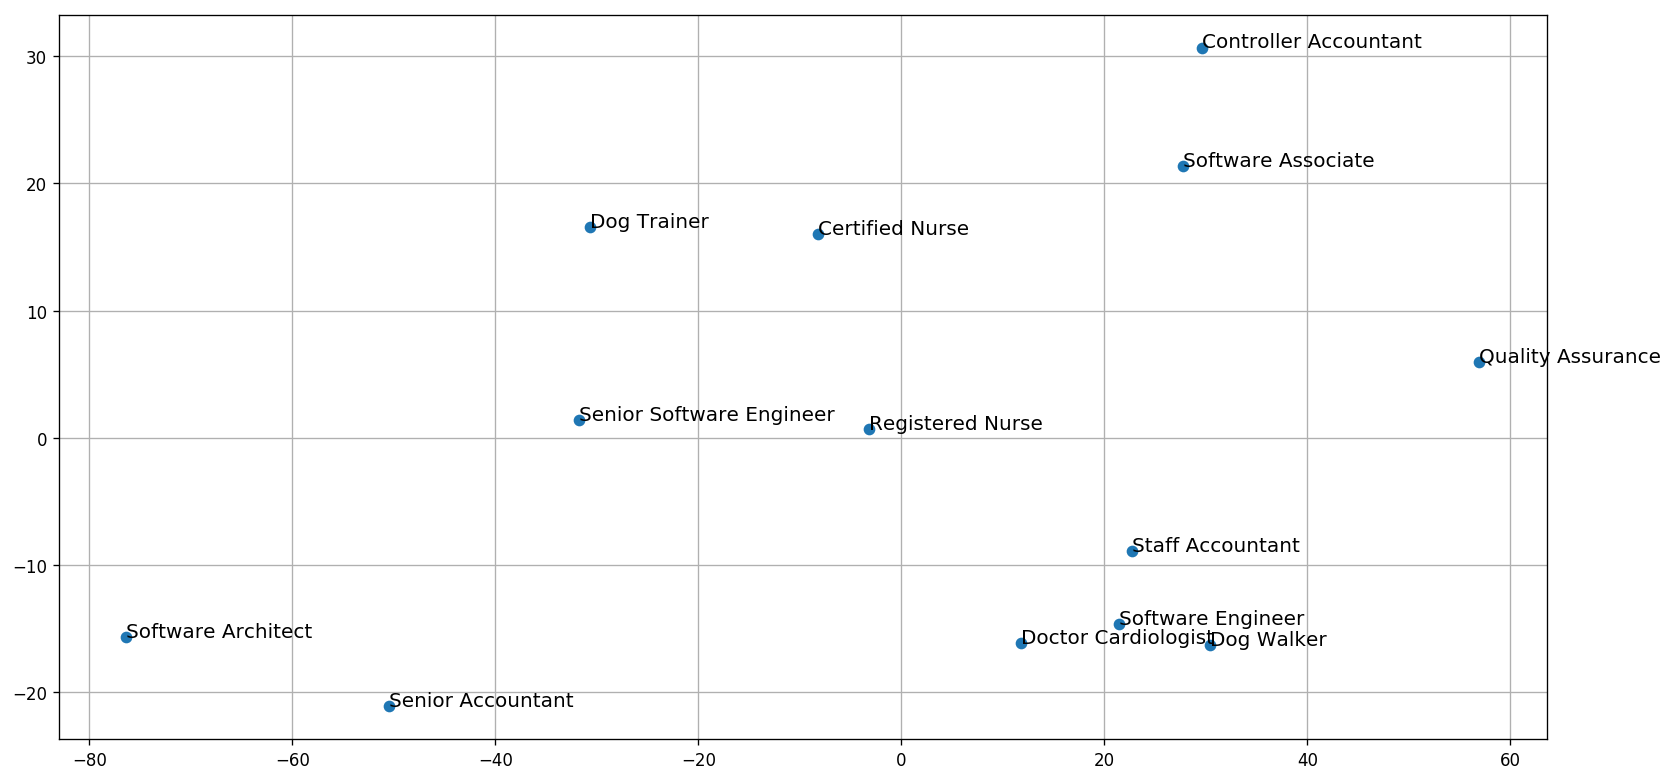

In [31]:
plt.figure(num=None, figsize=(16, 8), dpi=120, facecolor='w', edgecolor='k')
plt.grid()
plt.scatter(sentences_tsne[:,0], sentences_tsne[:,1])
for label, x, y in zip(CV,sentences_tsne[:,0], sentences_tsne[:,1]):
    font = {'size' : 12, 'weight' : 'normal'}
    plt.rc('font', **font)
    plt.annotate(label.split('.')[0], xy=(x, y), xytext=(0, 0), textcoords='offset points')

In [32]:
import numpy as np
from scipy.linalg import qr
from dppy.finite_dpps import FiniteDPP
from numpy import linalg as LA

seed = 0
rng = np.random.RandomState(seed)

In [33]:
eig_vecs, _ = qr(all_cvs_numpy)
eigenvals_sentences  = LA.eigvals(eig_vecs).astype('float64')

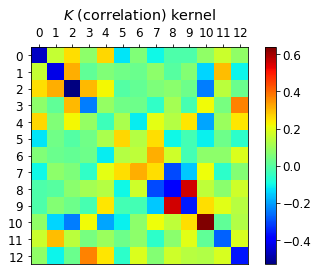

In [34]:
DPP = FiniteDPP(kernel_type='correlation',
                **{'K': (eig_vecs * eigenvals_sentences).dot(eig_vecs.T)})
DPP.plot_kernel()

In [44]:
rng = np.random.RandomState(seed)
DPP.flush_samples()
n_sets = 5
for _ in range(n_sets):
    DPP.sample_exact(mode='GS', random_state=rng,)

for x, samp in enumerate(DPP.list_of_samples):
    print("SET {} ---".format(x))
    print("--- ELEMENTS {}".format(samp))
    for i,j in enumerate(samp):
        print("      - {}".format(CV[j]))

SET 0 ---
--- ELEMENTS [11  5  6]
      - Dog Walker. Pets, 5 years. pet shop, free time, dog, walk, breed, pet, Sizes.
      - Staff Accountant. Finance, 15 years. IRS, Tax, SEC Reporting, Revenue Recognition, Consolidation, market and money, financial audit, fiscal and sales.
      - Senior Accountant. Finance, 18 years. Tax, IRS, SEC Reporting, Consolidation, market, Investments, sales Credit.
SET 1 ---
--- ELEMENTS [ 6  7 10]
      - Senior Accountant. Finance, 18 years. Tax, IRS, SEC Reporting, Consolidation, market, Investments, sales Credit.
      - Controller Accountant. Finance, 22 years. Management, SEC Reporting, Balance, sales, market, Consolidation, Revenue, Investments, audit.
      - Doctor Cardiologist. Health, 22 years. Specialist cardiovascular system, patient health, treatment, disease, medical, clinical
SET 2 ---
--- ELEMENTS [10  4  5]
      - Doctor Cardiologist. Health, 22 years. Specialist cardiovascular system, patient health, treatment, disease, medical, clini